In [11]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import numba
import numba.types as nt
from numba import jit,prange
import argparse
%matplotlib inline

In [12]:
def rate_network_params():
    # Function for defining all the rate network parameters defined on the paper
    
    parser = argparse.ArgumentParser()
    parser.add_argument('-Ne','--Ne',action="store",default=1024,type=int,help="Number of excitatory neurons")
    parser.add_argument('-Ni','--Ni',action="store",default=256,type=int,help="Number of inhibitory neurons")
    
    parser.add_argument('-tau_e','--tau_e',action="store",default=0.020,type=int or float,help="Time constant τe in s")
    parser.add_argument('-tau_i','--tau_i',action="store",default=0.010,type=int or float,help="Time constant τi in s")
    parser.add_argument('-tau_p','--tau_p',action="store",default=0.5,type=int or float,help="Time constant τp in s")
    parser.add_argument('-tau_w','--tau_w',action="store",default=300,type=int or float,help="Time constant τw in s")
    
    parser.add_argument('-c','--c',action="store",default=100 * 2 **(-10),help="Connection probability")
    parser.add_argument('-rmax','--rmax',action="store",default=200,help="Saturation firing rate")
    parser.add_argument('-I','--I',action="store",default=0.5,help="To specify mu and sigma in noise distribution")
    parser.add_argument('-dt','--dt',action="store",default=0.001,help="timestep in ms")
    parser.add_argument('-eta','--eta',action="store",default=5,help="eta")
    parser.add_argument('-kappa','--kappa',action="store",default=5,help="kappa")
    return parser.parse_args(args=[]) 

In [13]:
@numba.njit(nt.int64[::1](nt.int64[::1],nt.int64))
def delete(arr, num):
    # Delete an element from an array 
    
    mask = np.zeros(arr.shape[0], dtype=np.int64) == 0
    mask[np.where(arr == num)[0]] = False
    return arr[mask]

In [14]:
@numba.njit(nt.float64[:,::1](nt.float64,nt.int64,nt.int64,nt.int64,nt.boolean))
def change_weights(value,Na,Nb,Nconn,aut_flag=False):    
    # Function for changing/adding weights(synapses)

    W = np.zeros((Na,Nb))    
    for i in range(Na):  
        if aut_flag : # For wee and wii
            Nb_arr = delete(np.arange(Nb),i)
            C = np.random.choice(Nb_arr,Nconn,replace=False)
             
        else:
            C = np.random.choice(np.arange(Nb),Nconn,replace=False)   
            
        for j in C: 
            W[i][j] = value/(Nconn)
    return W

In [15]:
@numba.njit
def simulate_model(num_of_steps,I,c,Ne,Ni,p,re,ri,dt,τe,τi,τp,β_val,Wee,Wei,Wie,Wii,rmax,η,τw,k,w0,τc,wee_w,plas_on):
    #Function for simulation  
    
    we0  = np.nonzero(Wee)[0]      #Nonzero indices of Wee to keep track of i,j indices in dw/dt
    we1  = np.nonzero(Wee)[1]   
    r       = np.ones((Ne)) * k
    wei     = 1/(c*Ni)             #Wei[np.nonzero(Wei)][0]     #wei  = 1/c*Ni      
    w0      = 1/(c*Ne)             #w0   = 1/ (c *Ne)
    wmax    = 10*wee_w             #wmax = 10 * wee_w  

    #Plasticity on time if specified
    if plas_on:
      mins    = 60 * 10**3           # 1min
      plas_on_time = 6 * mins        # Plasticity on at 6mins

    #all below params for storing results
    sk = 5000                      #take re,ri every 5000 steps
    rec_steps = n=int(round(num_of_steps/sk))
    mean_re = np.zeros((rec_steps,Ne))
    mean_ri = np.zeros((rec_steps,Ni))
    p_list  = np.zeros((rec_steps))
    ti = 0  

    for i in range(1,num_of_steps): 
        
        #noise
        I_bg = np.random.normal(I, 0.1*I, Ne) 
        
        #Wee
        if i>=plas_on_time and plas_on:
           for wi in range(len(we0)):
            i_index = we0[wi]
            j_index = we1[wi] 
            Wee[i_index,j_index]  = np.minimum(np.maximum(Wee[i_index,j_index] + (dt/τw) * (((η * w0 * re[i_index]*re[j_index])/k**3) * (re[i_index]-(r[i_index]**2/k))),0),wmax) 
           
        
        #d/dt terms of p,re and ri       
        p    = np.minimum(np.maximum(p       + (dt/τp) * (-p  + 1-β_val*c * np.sum(wei*ri)),0),1)               
        re   = np.minimum(np.maximum(re      + (dt/τe) * (-re + p*np.dot(Wee,re)-np.dot(Wei,ri)+I_bg),0),rmax)                
        ri   = np.minimum(np.maximum(ri      + (dt/τi) * (-ri + np.dot(Wie,re)- np.dot(Wii,ri)),0),rmax) 

        
        #r          
        r    = np.minimum(np.maximum(r + (dt/τc) * (-r + re),0),rmax)
        
        if i% sk == 0 :
          ti = int(round(i/sk))
        mean_re[ti,:] += re/sk
        mean_ri[ti,:] += ri/sk
        p_list[ti] = p
        
        if i % mins == 0: #Print mean_re every 1 min for checking
         print(np.mean(mean_re)) 
    
    return mean_re,mean_ri,p_list

In [16]:
#All parameter definitions

args  = rate_network_params()

Ne    = args.Ne             # number of excitatory neurons
Ni    = args.Ni             # number of inhibitory neurons
τe    = args.tau_e          # time constant in ms
τi    =  args.tau_i
p     = 1                   # 1 for the absence of presynaptic inhibition
c     = args.c              # connection probability
rmax  = args.rmax           # firing rates rectified and saturated at rmax Hz
dt    = args.dt             # timestep in ms
I     = args.I              # Hz
N     = Ne+Ni               # Total no: of neurons
r_cNe = int(c*Ne)           # Number of excitatory connections
r_cNi = int(c*Ni)           # Number of inhibitory connections
τp    = args.tau_p          
η     = args.eta            #learning rate
τw    = args.tau_w          #
k     = args.kappa          #

mins = 60 * (10**3)         # 60 sec
num_of_steps = 60 * mins    # timesteps to solve diff.eqns.

plas_on = True              # plasticity on
β_val   = 0.05              # Beta 
pstar   = 1-β_val*k         # p*

w0    = 1                   # initial w0
wei_w = 1                   # Weights          
wie_w = 1.5
wii_w = 0.5

tc    = [90]                # tauc

Wii = change_weights(wii_w,Ni,Ni,r_cNi,True)
Wie = change_weights(wie_w,Ni,Ne,r_cNe,False)
Wei = change_weights(wei_w,Ne,Ni,r_cNi,False)


In [17]:
#Wee with noise:

wee_w = (1 + wei_w * wie_w/(1+wii_w )- I/k)/pstar/r_cNe
Wee = np.zeros((Ne,Ne))
aut_flag = True

for i in range(Ne):
  if aut_flag :
    Nb_arr = delete(np.arange(Ne),i)
    C = np.random.choice(Nb_arr,r_cNe,replace=False)            
  else:
    C = np.random.choice(np.arange(Ne),r_cNe,replace=False)  
  for j in C:
    Wee[i][j] = np.random.normal(wee_w,.0025,1)

In [18]:
start = time.time()
print("Starting Simulation with "+str(num_of_steps)+ " timesteps")

for t_index,τc in enumerate(tc):            
    re = np.ones((Ne)) * k     #re
    ri = np.ones((Ni)) * k     #ri
    p  = pstar                 #p
    mean_re,mean_ri,p_list = simulate_model(num_of_steps,I,c,Ne,Ni,p,re,ri,dt,τe,τi,τp,β_val,Wee,Wei,Wie,Wii,rmax,η,τw,k,w0,τc,wee_w,plas_on)
    
print("Simulation ended") 
stop = time.time()

print("Time elapsed: "+str(stop-start) + " secs")

Starting Simulation with 3600000 timesteps
0.0833437155084418
0.16668705534678227
0.2500306377234817
0.33337436890431316
0.41671816725607513
0.5000621197762991
0.5833443313027933
0.6665212118131045
0.7497250475042403
0.833048709491687
0.9164529021881034
0.9999407463667803
1.0835842406562706
1.1671639604937893
1.2501161477277047
1.3323120084350815
1.4144971007209266
1.4975478738256818
1.5816071209964544
1.6664019240925625
1.751739198007643
1.8361239364631627
1.9165647904076883
1.9931229283923946
2.069711079972938
2.1512161297018695
2.240743844794425
2.334871621987707
2.466749221082174
2.695910371835448
2.9129672102559714
3.133729896066155
3.3547090701405313
3.5744024589686236
3.7767613009295617
3.9774003734065224
4.1970863585140235
4.411210257867902
4.623408483463916
4.834408162617315
5.0494600427188185
5.260980846625308
5.476702449960587
5.687056803865074
5.896008978841734
6.10639409801137
6.324137630102011
6.532820632322006
6.74050147357006
6.954080512246749
7.1700095776355806
7.38495

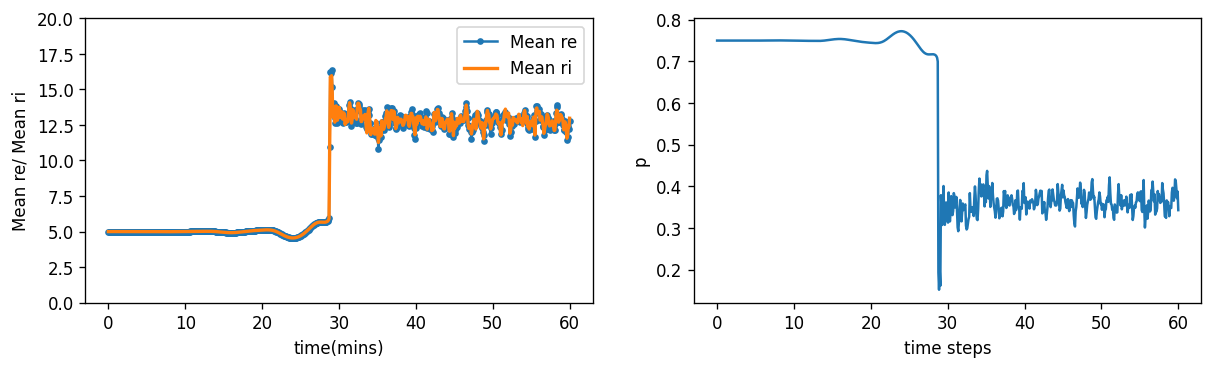

In [19]:
#Plot results
t = np.linspace(0,60,720)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi = 120)
ax[0].plot(t,np.mean(mean_re,axis=1),marker = ".", label = "Mean re")
ax[0].plot(t,np.mean(mean_ri,axis=1),lw = 2,label = "Mean ri")
ax[0].set(xlabel='time(mins)', ylabel='Mean re/ Mean ri',ylim=[0,20])
ax[0].legend()
ax[1].plot(t,p_list)
ax[1].set(xlabel='time steps', ylabel='p')
plt.subplots_adjust(bottom=0.09, hspace=0.1)
plt.show() 